<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
!pip install kaggle

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

SMALL DATASET(about 3000 pictuares)

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tommykamaz/faces-dataset-small

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 3.99G/3.99G [03:33<00:00, 24.4MB/s]
100% 3.99G/3.99G [03:33<00:00, 20.1MB/s]


In [ ]:
!mkdir images
!unzip -q -o faces-dataset-small.zip -d images | awk 'BEGIN {ORS=" "} {if(NR%50==0)print "."}'

mkdir: cannot create directory ‘images’: File exists


LARGE DATASET(70000 pictuares)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!unzip -q /content/gdrive/MyDrive/faces.zip -d images

In [4]:
DATA_DIR = './images/'

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
  print('Dataset size = ', len(train_ds))
  train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  return train_dl

In [7]:
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

In [8]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
image_size = 128
batch_size = 32

#TODO: build dataloader and transfer it to device

train_dl = DeviceDataLoader(get_dataloader(image_size, batch_size), device) 

Dataset size =  70000


In [10]:
len(train_dl)

2188

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [11]:
discriminator =  nn.Sequential(
    # input: 3 x 128 x 128
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 256 x 16 x 16
            
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [12]:
from torch.nn.modules.activation import Tanh
latent_size = 100 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 64 x 64

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    # out: 3 x 128 x 128 
    nn.Tanh()
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [13]:
lr = 0.0001

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

model['discriminator'].to(device)
model['generator'].to(device)

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_r

In [14]:
def fit(model, train_dl, criterion, epochs, lr):
  # TODO: build optimizers and train your GAN
  
  optimizer = {
    "discriminator": torch.optim.Adam(model['discriminator'].parameters(), lr=lr, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(model['generator'].parameters(), lr=lr, betas=(0.5, 0.999))
  }

  loss_d = []
  loss_g = []

  for epoch in tqdm(range(epochs)):
    model['discriminator'].train()
    model['generator'].train()
    torch.cuda.empty_cache()
    loss_d_per_epochs = []
    loss_g_per_epochs = []

    for  x_batch, _ in tqdm(train_dl):
      # Discriminator
      optimizer['discriminator'].zero_grad()
      real_preds = model['discriminator'](x_batch)
      real_targets = torch.ones(x_batch.shape[0], 1).to(device)
      real_loss = criterion['discriminator'](real_preds, real_targets)

      latent = torch.randn(x_batch.shape[0], latent_size, 1, 1).to(device)
      fake_img = model['generator'](latent)
      fake_preds = model['discriminator'](fake_img)
      fake_targets = torch.zeros(x_batch.shape[0], 1).to(device)
      fake_loss = criterion['discriminator'](fake_preds, fake_targets)

      loss_d_epoch = fake_loss + real_loss
      loss_d_epoch.backward()
      optimizer['discriminator'].step()
      loss_d_per_epochs.append(loss_d_epoch.item())

      # Generator
      optimizer['generator'].zero_grad()

      latent = torch.randn(x_batch.shape[0], latent_size, 1, 1).to(device)
      preds = model['discriminator'](model['generator'](latent))
      targets = torch.ones(x_batch.shape[0], 1).to(device)

      loss_g_epoch = criterion['generator'](preds, targets)
      loss_g_epoch.backward()
      optimizer['generator'].step()
      loss_g_per_epochs.append(loss_g_epoch.item())

    loss_d.append(np.mean(loss_d_per_epochs))
    loss_g.append(np.mean(loss_g_per_epochs))

    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}".format(
            epoch+1, epochs, 
            loss_g[-1], loss_d[-1]))

  return loss_d, loss_g 

In [ ]:
epochs = 7

loss_d, loss_g = fit(model, train_dl, criterion, epochs, lr)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [1/7], loss_g: 7.1447, loss_d: 0.2048


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [2/7], loss_g: 7.0358, loss_d: 0.1574


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [3/7], loss_g: 7.1771, loss_d: 0.1591


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [4/7], loss_g: 7.1779, loss_d: 0.1405


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [5/7], loss_g: 7.0810, loss_d: 0.1502


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [6/7], loss_g: 6.9790, loss_d: 0.1290


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [7/7], loss_g: 7.1936, loss_d: 0.1385


In [23]:
epochs = 13

loss_d2, loss_g2 = fit(model, train_dl, criterion, epochs, lr)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [1/13], loss_g: 7.2464, loss_d: 0.1119


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [2/13], loss_g: 7.4632, loss_d: 0.1260


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [3/13], loss_g: 7.3324, loss_d: 0.1095


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [4/13], loss_g: 7.5460, loss_d: 0.1145


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [5/13], loss_g: 7.5807, loss_d: 0.0903


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [6/13], loss_g: 7.5319, loss_d: 0.0962


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [7/13], loss_g: 7.5492, loss_d: 0.1167


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [8/13], loss_g: 7.6879, loss_d: 0.0929


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [9/13], loss_g: 7.8915, loss_d: 0.0895


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [10/13], loss_g: 7.7529, loss_d: 0.0958


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [11/13], loss_g: 8.2293, loss_d: 0.0784


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [12/13], loss_g: 7.6891, loss_d: 0.1032


  0%|          | 0/2188 [00:00<?, ?it/s]

Epoch [13/13], loss_g: 7.9219, loss_d: 0.0925


In [17]:
torch.save(model['discriminator'].state_dict(), "/content/gdrive/MyDrive/discr_weights6.pth")
torch.save(model['generator'].state_dict(), "/content/gdrive/MyDrive/gener_weights6.pth")

In [21]:
model['discriminator'].load_state_dict(torch.load('/content/gdrive/MyDrive/discr_weights5.pth'))
model['generator'].load_state_dict(torch.load('/content/gdrive/MyDrive/gener_weights5.pth'))

<All keys matched successfully>

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

SMALL DATASET(40 epochs)

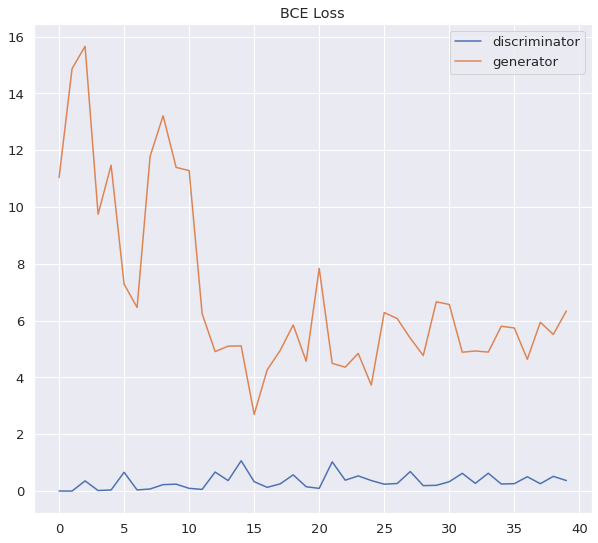

In [ ]:
plt.figure(figsize=(10, 9))
plt.plot(np.arange(40), loss_d, label='discriminator')
plt.plot(np.arange(40), loss_g, label='generator')
plt.grid(True)
plt.legend()
plt.title('BCE Loss')
plt.show()

LARGE DATASET(batch_size=128)

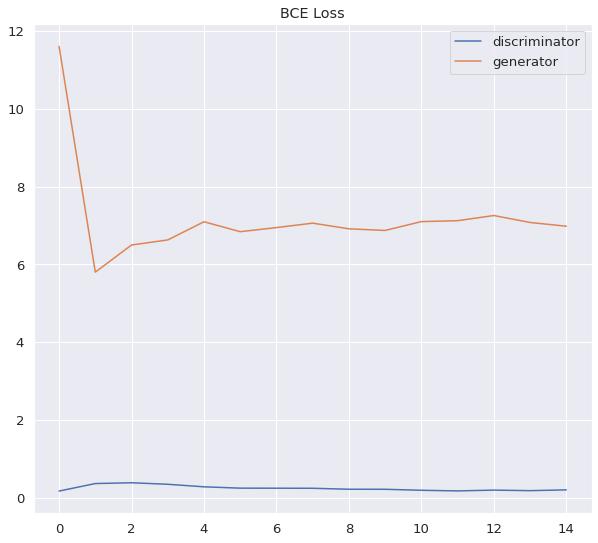

In [ ]:
plt.figure(figsize=(10, 9))
plt.plot(np.arange(15), loss_d + loss_d2, label='discriminator')
plt.plot(np.arange(15), loss_g + loss_g2, label='generator')
plt.grid(True)
plt.legend()
plt.title('BCE Loss')
plt.show()

LARGE DATASET(batch_size=32)

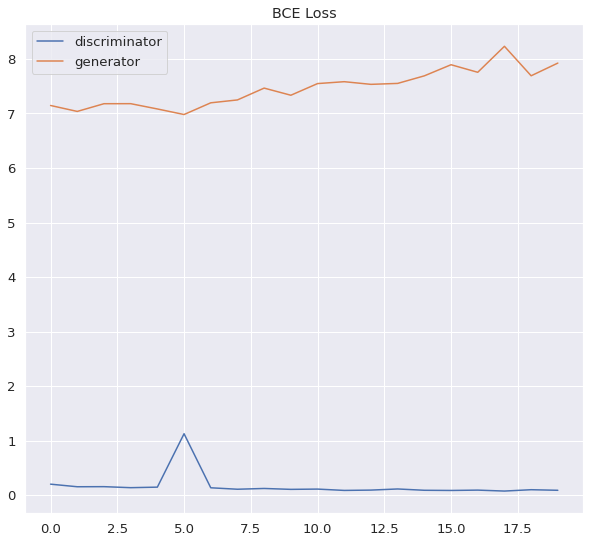

In [27]:
plt.figure(figsize=(10, 9))
plt.plot(np.arange(20), loss_d + loss_d2, label='discriminator')
plt.plot(np.arange(20), loss_g + loss_g2, label='generator')
plt.grid(True)
plt.legend()
plt.title('BCE Loss')
plt.show()

Лучше всего видно по 2 графику(на 128 обьектах в батче)(тк тут одна эпоха содержит меньшее число итераций и соответственно детализация графика выше). Можно заметить, что у дискриминатора лосс сначала немного растет, а затем начинает падать, у генератора же, наоборот, лосс сначала падает, а затем начинает расти. Что говорит о том, что дискриминатор адаптируется и начинает отличать картинки.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

SMALL DATASET(40 epochs)

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [15]:
def show_images(generated, nrow=2):
  # TODO: show generated images
  plt.figure(figsize=(8, 8))
  plt.axis('Off')
  plt.imshow(make_grid(denorm(generated.detach().cpu()), nrow).permute(1, 2, 0))

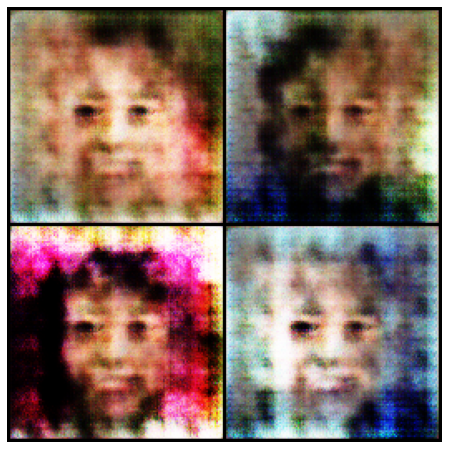

In [ ]:
show_images(fake_images)

Довольно страшно выглядит. Но тут и обучающих данных немного. Хоть какие-то очертания лиц видны ;)

LARGE DATASET(7 epochs)

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

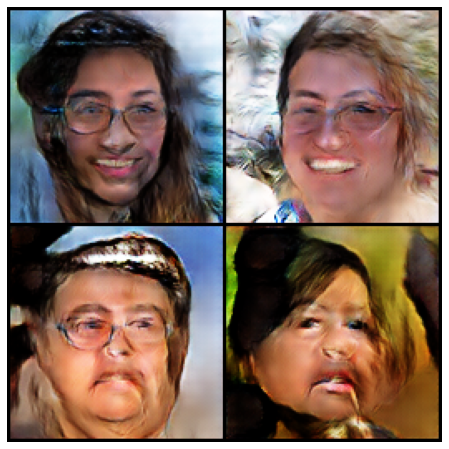

In [ ]:
show_images(fake_images)

Уже на порядок лучше. Но попробуем обучить еще. В сумме 20 эпох.

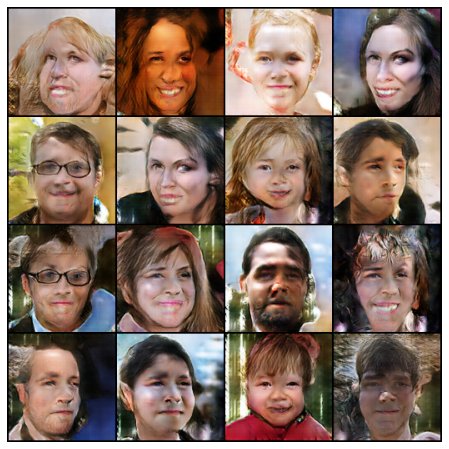

In [28]:
n_images = 16

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)
show_images(fake_images, 4)

Как вам качество получившихся изображений?

Изображения по-прежнему далеки от идеала. Много артефактов. Но в целом есть сходства с человеческими лицами.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#from torchvision.models import efficientnet_v2_l
#effnet = efficientnet_v2_l(pretrained=True).to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
from torchvision.models import resnet34

resnet = resnet34(pretrained=True).to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Размер данных большой - поэтому будем обучаться по батчам размера 500(Чтобы было хотя бы 1000 обьектов для обучения 1NN на каждой итерации).

In [17]:
newmodel = torch.nn.Sequential(*(list(resnet.children())[:-1]))

In [18]:
train_dl = DeviceDataLoader(get_dataloader(128, 500), device)

Dataset size =  70000


In [ ]:
newmodel

In [25]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

loo = LeaveOneOut()
accuracy = 0

for true_imgs, _ in train_dl:
  class_size = true_imgs.size(0)

  # Get fake images
  latent = torch.randn(class_size, latent_size, 1, 1).to(device)
  fake_imgs = model['generator'](latent)

  #Train dataset, Shuffling
  train_ds = torch.cat((true_imgs, fake_imgs), dim=0)
  targets = torch.cat((torch.ones(class_size), torch.zeros(class_size)), dim=0)
  idx = torch.randperm(train_ds.size(0))
  train_ds = train_ds[idx]
  targets = targets[idx]
  
  # Get features from images
  features = newmodel(train_ds)[:, :, 0, 0].detach().cpu()

  for train_idx, test_idx in loo.split(features):
    knn = KNeighborsClassifier(1).fit(features[train_idx], targets[train_idx])
    accuracy += accuracy_score(targets[test_idx], knn.predict(features[test_idx]))

accuracy /= 140000

In [26]:
print("Leave-one-out-1-NN classifier accuracy: ", accuracy)

Leave-one-out-1-NN classifier accuracy:  0.8423857142857143


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Чем меньше точность 1NN алгоритма тем лучше, так как это говорит о том, что обьекты настолько сильно перемешаны, что алгоритм не может отличить их друг от друга(фейковые с реальными). В идеаль получить точность близкую к 0.5(что соответствует случайному алгоритму). Тут же мы получили 0.84. Результат далек от идеала, но в целом алгоритм ошибается в 15 процентах случаев. 

Я рассматривал датасет по кускам в 1000 обьектов(500 фейковых и 500 настоящих) и для каждого обьекта брал фичи, которые выдает resnet34 перед последним слоем. В целом на таком небольшом обьеме выборки на каждой итерации 1NN классификатору работать проще. Это заметно по графикам ниже.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

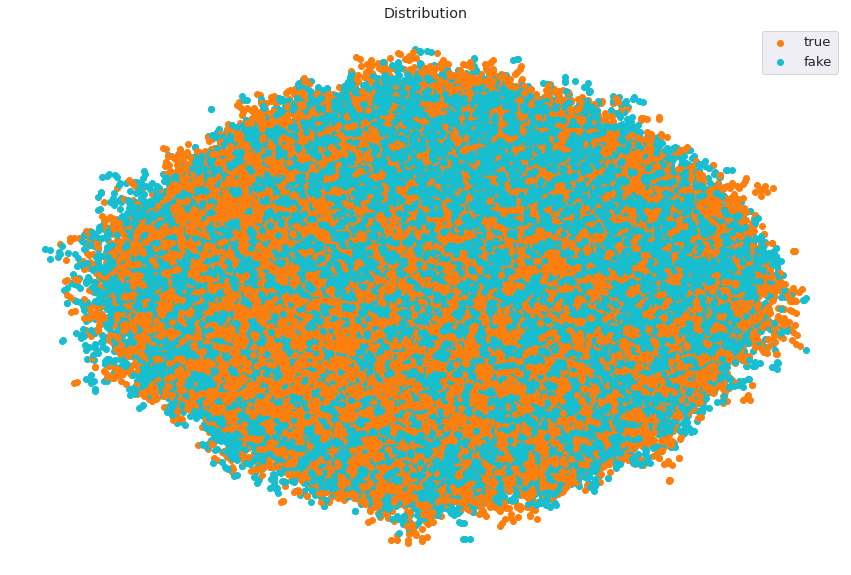

In [22]:
from sklearn.manifold import TSNE

plt.figure(figsize=(15, 10))
for true_imgs, _ in train_dl:
  class_size = true_imgs.size(0)

  # Get fake images
  latent = torch.randn(class_size, latent_size, 1, 1).to(device)
  fake_imgs = model['generator'](latent)

  #Train dataset
  train_ds = torch.cat((true_imgs, fake_imgs), dim=0)
  targets = torch.cat((torch.ones(class_size), torch.zeros(class_size)), dim=0)
  
  # Get features from images
  features = newmodel(train_ds)[:, :, 0, 0].detach().cpu()

  # downsizing
  features = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(features)
  true_features = features[:class_size]
  fake_features = features[class_size:]
  
  plt.scatter(true_features[:, 0], true_features[:, 1], c='#ff7f0e')
  plt.scatter(fake_features[:, 0], fake_features[:, 1], c='#17becf')

plt.legend(['true', 'fake'])
plt.axis('Off')
plt.title('Distribution')
plt.show()

Изобразим только точки из последней итерации.

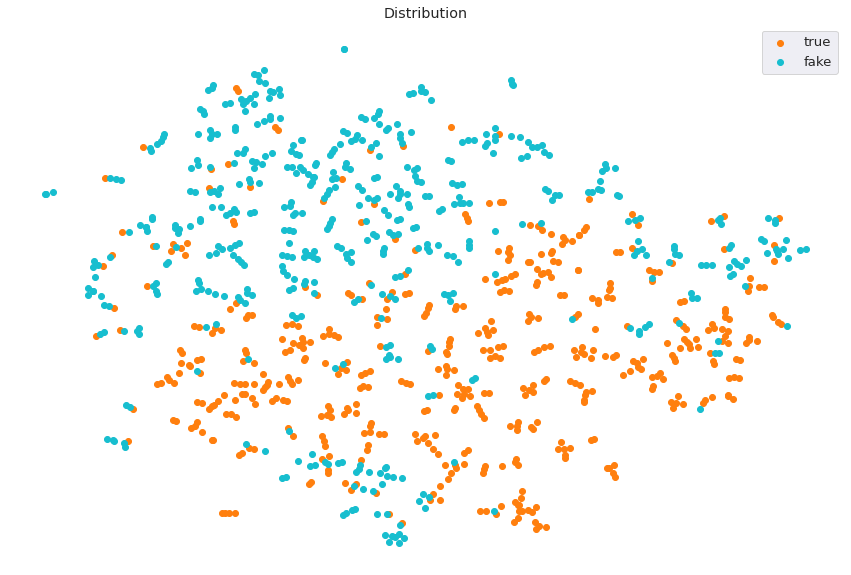

In [23]:
plt.figure(figsize=(15, 10))
plt.scatter(true_features[:, 0], true_features[:, 1], c='#ff7f0e', label='true')
plt.scatter(fake_features[:, 0], fake_features[:, 1], c='#17becf', label='fake')
plt.legend()
plt.axis('Off')
plt.title('Distribution')
plt.show()

Прокомментируйте получившийся результат:

Видно, что все таки обьекты в целом между собой довольно неплохо перемешаны, но все таки есть области скопления в большинстве точек определенного класса. Если же рассмотреть по 1000 обьектов(те тот набор на котором работает классификатор из прошлого пункта), то тут видно, что обьекты не так сильно перемешаны(как хотелось бы), но все таки есть область, в которых обьекты немного перемешаны. Это как раз кореллирует с результатом из предыдущего пункта.